<a href="https://colab.research.google.com/github/Savvy-Slowley/Butterfly/blob/main/Butterfly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplcyberpunk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import zipfile
import os
import pandas as pd
import PIL
from pathlib import Path
import plotly.express as px
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
import mplcyberpunk

In [3]:
# Unzip training set
local_zip = '/content/butterfly images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./butterfly')

zip_ref.close()

In [4]:
# Loading images from the folder as a list with a count of files
train_ds = './butterfly/images'
print(f"There are {len(os.listdir(train_ds))} images in  the training set")

There are 853 images in  the training set


In [5]:
# Seeing how the files are named in the folder
file_names = os.listdir(train_ds)
file_names[:10]

['wyd50bba50.jpg',
 'ni2288c16c.jpg',
 'uxe3d08a46.jpg',
 'ux9c6bb756.jpg',
 'osa4ad6b40.jpg',
 'rvfa3418a4.jpg',
 'unfa87ed41.jpg',
 'rs645c744d.jpg',
 'lo3c0fc95a.jpg',
 'nu079d86bf.jpg']

In [6]:
# Loading labels with a preview
labels = pd.read_csv('/content/butterfly/butterfly images.csv')
labels.head()

,image,name,stage,side
0,ggc1e08cbc,monarch,adult,ventral
1,gh150f104b,tiger,adult,both
2,gh20ab0d9c,black,adult,dorsal
3,gh2d5c8c79,monarch,adult,dorsal
4,gh6adf74a4,pipevine,adult,dorsal


In [7]:
# Renaming image column to match images in the folder name
labels['image'] = labels['image']+'.jpg'
labels1 = labels[['image', 'name']]
labels1.head()

,image,name
0,ggc1e08cbc.jpg,monarch
1,gh150f104b.jpg,tiger
2,gh20ab0d9c.jpg,black
3,gh2d5c8c79.jpg,monarch
4,gh6adf74a4.jpg,pipevine


In [8]:
# Test whether the filename string matches the format .jpg and gives me all unidentified images
# Just incase any images have issues
path = Path(train_ds).rglob("*.jpg") 
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [9]:
# Made to remove corrupted images
#corrupted =['Insert corrupt image name here ']
#labels1 = labels1.drop(labels1[labels1['image'].isin(corrupted)].index, axis=0)

In [10]:
classes = list(labels1['name'].unique())
class_dict = dict(zip(classes, range(len(classes))))
print('Number of Classes:',len(classes))
print(classes)
print(class_dict)

Number of Classes: 6
['monarch', 'tiger', 'black', 'pipevine', 'viceroy', 'spicebush']
{'monarch': 0, 'tiger': 1, 'black': 2, 'pipevine': 3, 'viceroy': 4, 'spicebush': 5}


In [11]:
# Shows count of each label
fig = px.bar(labels1['name'].value_counts())
fig.show()

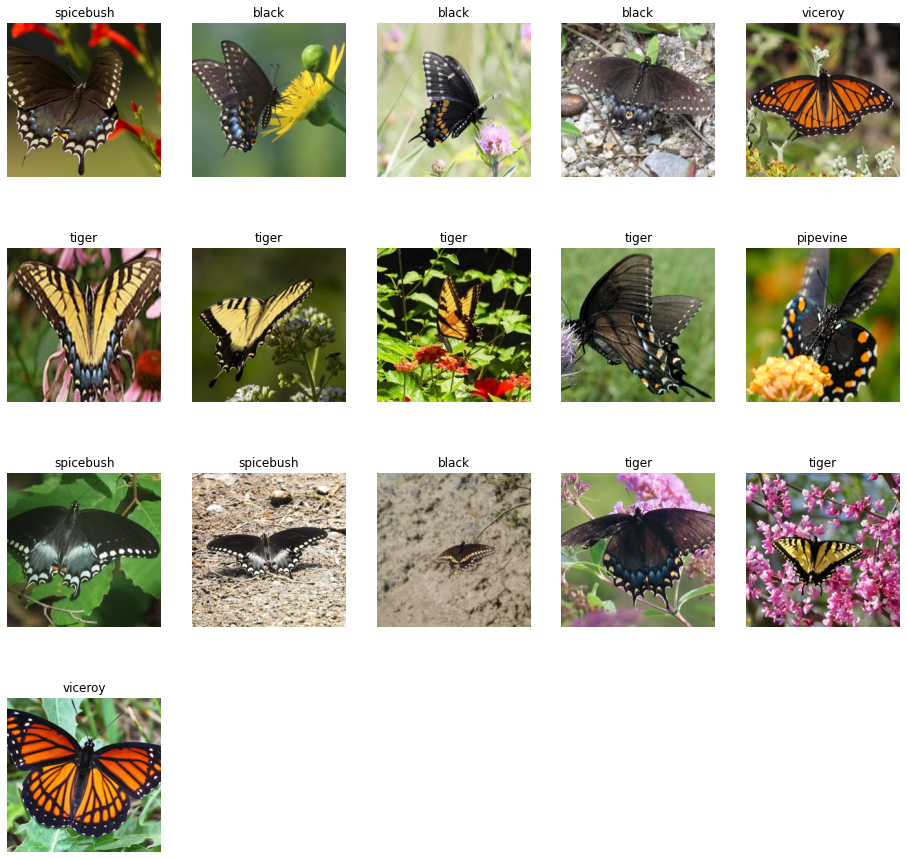

In [12]:
# Print random images and their labels

def show_random_training_image():
    random_index = random.choice(labels1.index)
    img_path = labels1['image'][random_index]
    label = labels1['name'][random_index]
    complete_path = train_ds + '/' + img_path
    image = mpimg.imread(complete_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)

plt.figure(figsize=(16, 20))
for i in range(16):
    ax = plt.subplot(5, 5, i+1)
    show_random_training_image()

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels1,
    directory=train_ds,
    x_col='image',
    y_col='name',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=labels1,
    directory=train_ds,
    x_col='image',
    y_col='name',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

Found 683 validated image filenames belonging to 6 classes.
Found 170 validated image filenames belonging to 6 classes.


In [15]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [16]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Train the model
history = model.fit(train_generator, epochs=50, steps_per_epoch=22, validation_data = validation_generator, verbose = 1, validation_steps=3)

Epoch 1/50
22/22 [==============================] - 22s 817ms/step - loss: 1.8605 - accuracy: 0.2020 - val_loss: 1.7322 - val_accuracy: 0.2292
Epoch 2/50
22/22 [==============================] - 9s 420ms/step - loss: 1.7264 - accuracy: 0.2372 - val_loss: 1.6464 - val_accuracy: 0.2917
Epoch 3/50
22/22 [==============================] - 9s 416ms/step - loss: 1.5436 - accuracy: 0.3294 - val_loss: 1.6417 - val_accuracy: 0.3750
Epoch 4/50
22/22 [==============================] - 9s 417ms/step - loss: 1.4277 - accuracy: 0.3865 - val_loss: 1.4901 - val_accuracy: 0.3229
Epoch 5/50
22/22 [==============================] - 9s 413ms/step - loss: 1.3644 - accuracy: 0.4217 - val_loss: 1.3151 - val_accuracy: 0.4479
Epoch 6/50
22/22 [==============================] - 10s 454ms/step - loss: 1.3384 - accuracy: 0.4231 - val_loss: 1.2860 - val_accuracy: 0.4688
Epoch 7/50
22/22 [==============================] - 11s 485ms/step - loss: 1.2312 - accuracy: 0.4802 - val_loss: 1.2994 - val_accuracy: 0.4479
Epo

In [18]:
pretrained_model = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3)) # I don't want to include the top because I want to customize that

87924736/87910968 [==============================] - 0s 0us/step


In [19]:
# freeze the layers so they aren't trainable
for layer in pretrained_model.layers:
  layer.trainable = False

In [20]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 alization)                     )                                                      

In [21]:
input_layer = tf.keras.Input(shape=(224, 224, 3))
x = pretrained_model (input_layer)

In [22]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(x)
# Add a dropout rate of 50%
x = tf.keras.layers.Dropout(0.5)(x)  
# Add a fully connected layer with 128 hidden units and ReLU activation
x = tf.keras.layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 50%
x = tf.keras.layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(6, activation='softmax')(x)  

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(), metrics='accuracy')

In [24]:
# Train the model
history = model.fit(train_generator, epochs=150, steps_per_epoch=22, validation_data = validation_generator, verbose = 1, validation_steps=3)

Epoch 1/150
22/22 [==============================] - 11s 444ms/step - loss: 0.7224 - accuracy: 0.7233 - val_loss: 0.7455 - val_accuracy: 0.7188
Epoch 2/150
22/22 [==============================] - 10s 441ms/step - loss: 0.5153 - accuracy: 0.8097 - val_loss: 0.5519 - val_accuracy: 0.7604
Epoch 3/150
22/22 [==============================] - 9s 416ms/step - loss: 0.4756 - accuracy: 0.8097 - val_loss: 0.4959 - val_accuracy: 0.8229
Epoch 4/150
22/22 [==============================] - 9s 415ms/step - loss: 0.4451 - accuracy: 0.8082 - val_loss: 0.4809 - val_accuracy: 0.8333
Epoch 5/150
22/22 [==============================] - 9s 415ms/step - loss: 0.4609 - accuracy: 0.8199 - val_loss: 0.5313 - val_accuracy: 0.8125
Epoch 6/150
22/22 [==============================] - 10s 442ms/step - loss: 0.3851 - accuracy: 0.8389 - val_loss: 0.5380 - val_accuracy: 0.8125
Epoch 7/150
22/22 [==============================] - 9s 414ms/step - loss: 0.3570 - accuracy: 0.8682 - val_loss: 0.6537 - val_accuracy: 0.7

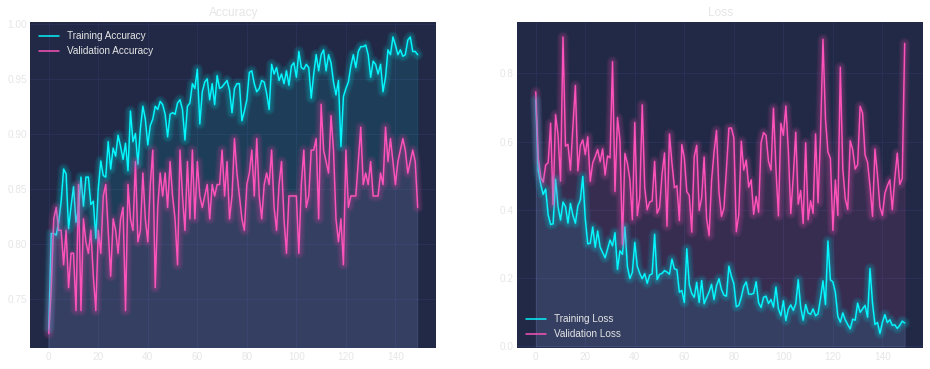

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 6))
plt.style.use('cyberpunk')
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
mplcyberpunk.add_glow_effects()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
mplcyberpunk.add_glow_effects()

plt.show()